# UNet model for semantic segmentation

In [1]:
import importlib
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
from matplotlib import pyplot as plt
import albumentations as A
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from pathlib import Path

# Any results you write to the current directory are saved as output.
import utils as my_utils
importlib.reload(my_utils)

# my own custom class to generate augmented data
from data_generator import DataGenerator
# utility functions implemented in a separate file for reusability
from utils import dice_coef, f1score, sensitivity, specifity, make_pair, loadAndProcessImages, get_image_with_mask_imposed, make_prediction

### Loading data and creating sets for Train, Validation and Test
After loading training data I am using train_test_split to split data into training and validation sets

In [2]:
dataset_path = Path("./A3_Dataset/dataset1/")
list(dataset_path.iterdir())

[PosixPath('A3_Dataset/dataset1/.DS_Store'),
 PosixPath('A3_Dataset/dataset1/annotations_prepped_train'),
 PosixPath('A3_Dataset/dataset1/images_prepped_train'),
 PosixPath('A3_Dataset/dataset1/annotations_prepped_test'),
 PosixPath('A3_Dataset/dataset1/images_prepped_test')]

In [3]:
X = list((dataset_path / "images_prepped_train").glob("*.png"))
y = list((dataset_path / "annotations_prepped_train").glob("*.png"))

sorted(X), sorted(y);

# convert training data into training and validation sets
train_imgs, val_imgs, train_labels, val_labels = train_test_split(X, y, test_size=0.20, random_state=42)

test_imgs = list((dataset_path / "images_prepped_test").glob("*.png"))
test_labels = list((dataset_path / "annotations_prepped_test").glob("*.png"))
sorted(test_imgs), sorted(test_labels);

### Pairing each Image with it's mask. Train Pair, Validation Pair and Test Pair are arrays of tuples

In [4]:
# creating tuples of image and mask
train_pair = make_pair(train_imgs, train_labels)
val_pair = make_pair(val_imgs, val_labels)
test_pair = make_pair(test_imgs, test_labels)

### COLORS: randomly generated 12 colors for class boundary.
### img_size: Tuple specifiying the dimension our network expects of the input image. Original images has a ratio 3:4 but the size is not divisible by 2 and cause issue for decoder. So I chose 192x256 as numbers divisible by 2 many times and also they maintain the 3:4 ratio.

In [5]:
COLORS = np.random.randint(0, 255, size=(12, 3),dtype="uint8")
img_size = (192, 256)

### Helper function that will plot passed images with their corresponding titles, 3 in a row.

In [6]:
def plot_images(images, titles):
    for i in range(len(images)):
        idx = i % 3
        if idx == 0:
            plt.figure(figsize=(25,25))
        plt.subplot(1, 3, idx+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

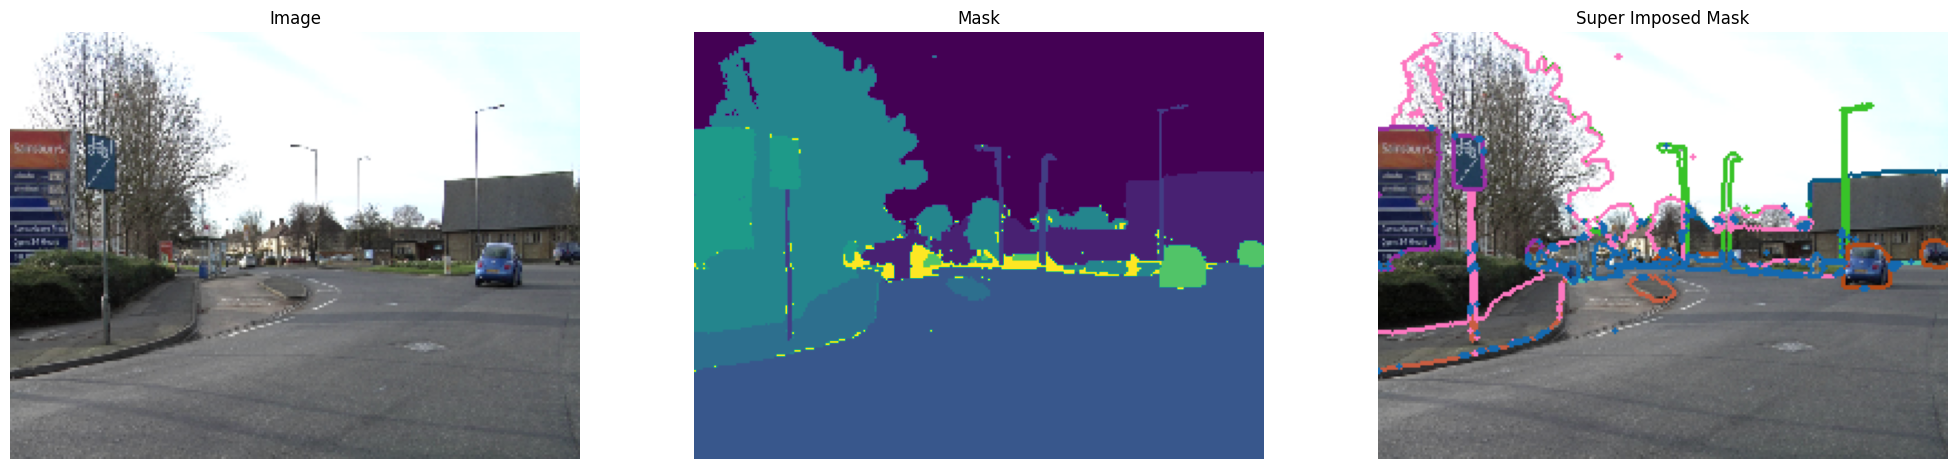

In [7]:
## Plotting a random pair with it's mask imposed

img, mask = loadAndProcessImages(train_pair, img_size)
super_imposed_image = get_image_with_mask_imposed(img, mask[:, :, 0], 12, COLORS)
plot_images([img/255, mask, super_imposed_image/255], ['Image', 'Mask', 'Super Imposed Mask'])

### Transformations to be used for data augmentation.

In [8]:
transformer = A.Compose([
    A.RandomCrop(width=256, height=256, p=0.5),
    A.OneOf([
        A.HorizontalFlip(p=0.6),
        A.VerticalFlip(p=0.4)
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=35, p=1.0),
    A.Resize(height=img_size[0], width=img_size[1]),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
])

validation_normaliser = A.Compose([
    A.Resize(height=img_size[0], width=img_size[1]),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
])

### Instances of DataGenerator class, implemented myself.
Data generator class takes list of tuples, transformer function if you want to apply, batch size and dimensions. Data generator will always return a data instance after applying transformation so it is highly possible that if you ask for same data again, it will come back with a different augmentation. You can see this in action below, I am calling same image instance 3 times, but it is appearing with a slightly different augmentation.

In [9]:
train_generator = DataGenerator(train_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3), shuffle=True)
train_steps = train_generator.__len__()
train_steps

73

In [10]:
test_generator = DataGenerator(test_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3), shuffle=True)
test_steps = test_generator.__len__()
test_steps

25

In [11]:
val_generator = DataGenerator(val_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(192, 256, 3) (192, 256)
(192, 256, 3) (192, 256)
(192, 256, 3) (192, 256)


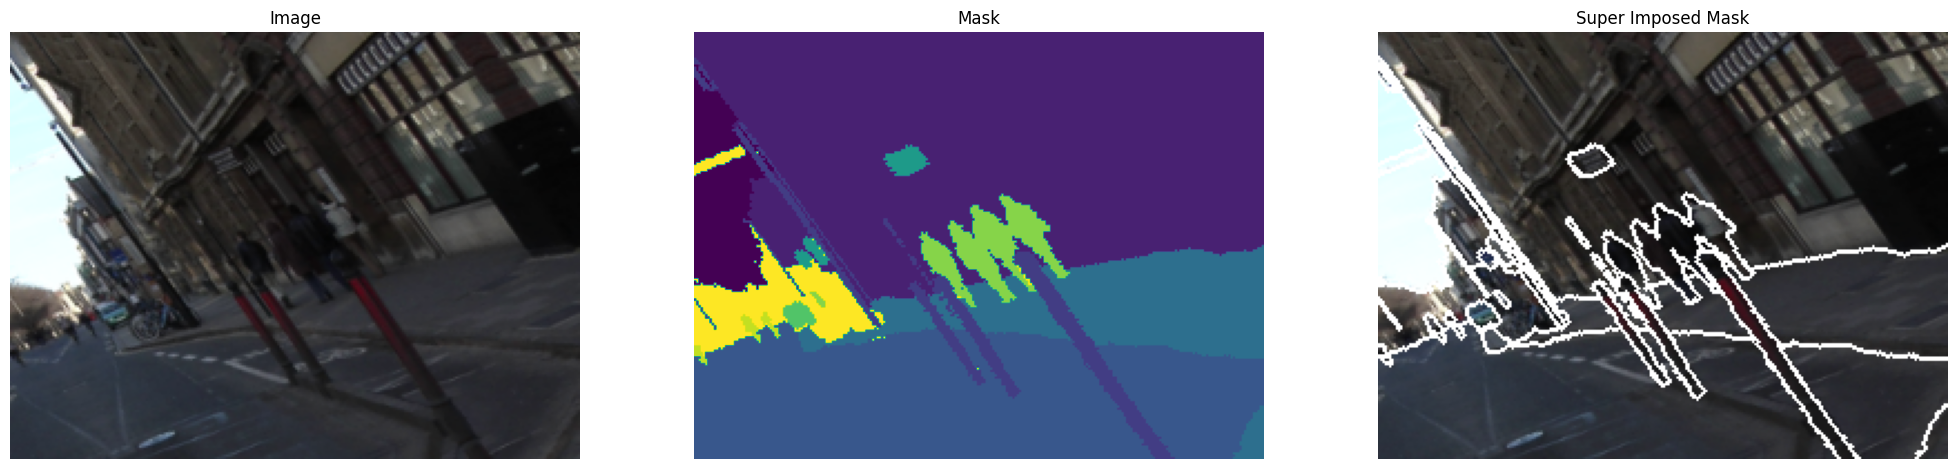

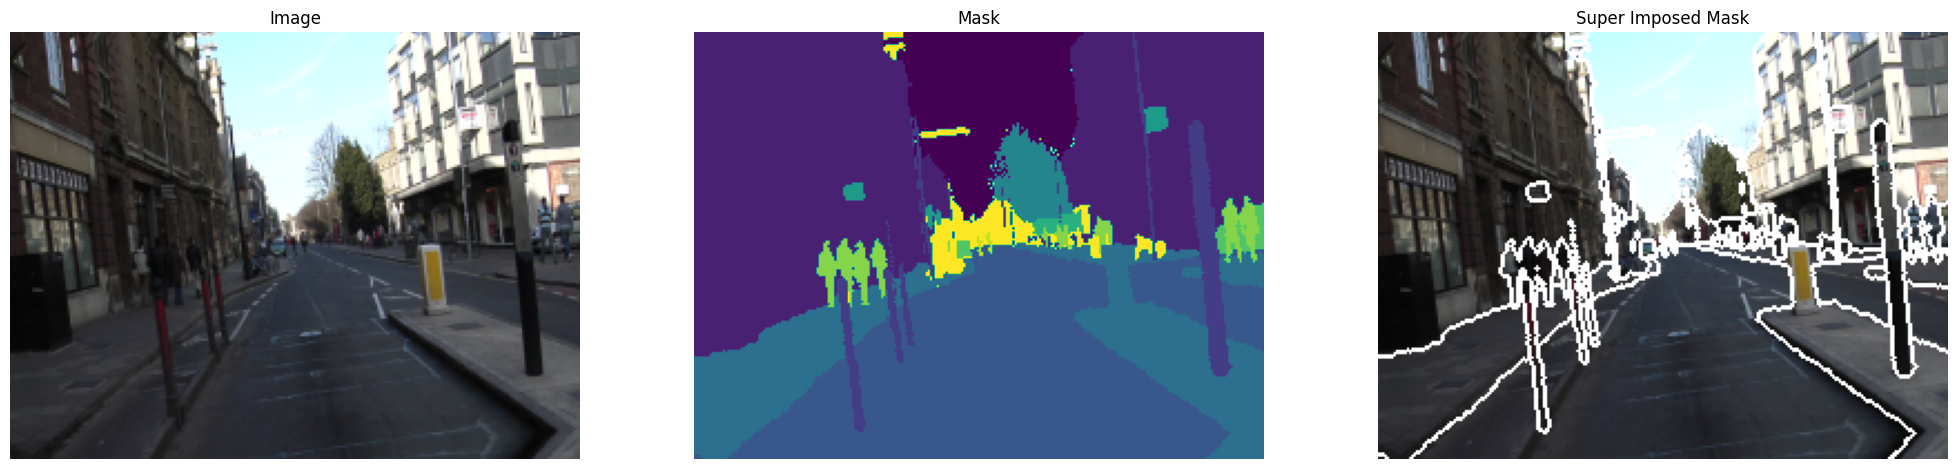

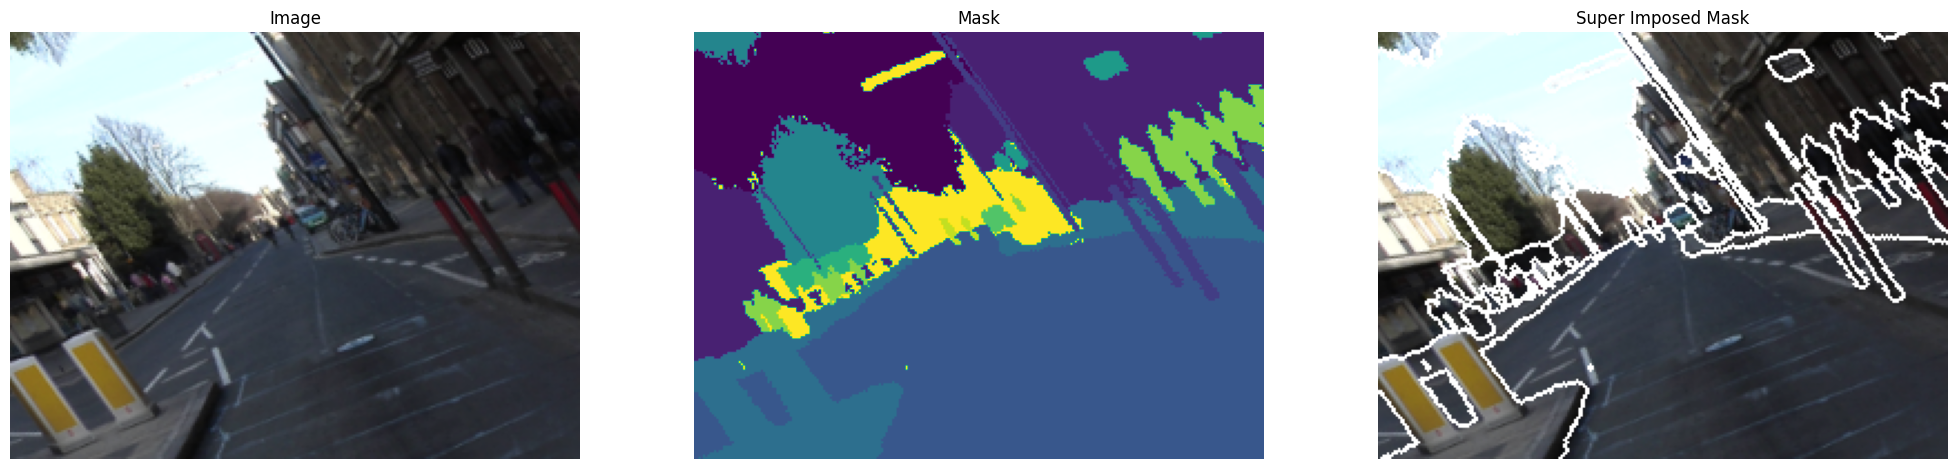

In [12]:
for i in range(3):
    img_batch, mask_batch = train_generator[10]
    img = img_batch[0]
    mask = mask_batch[0]
    mask = np.argmax(mask,axis=2)
    print(img.shape, mask.shape)
    super_imposed_image = get_image_with_mask_imposed(img, mask, 12, COLORS)
    plot_images([img, mask, super_imposed_image], ['Image', 'Mask', 'Super Imposed Mask'])

## Classic UNet implementation. You can see functions of conv block for encoders and de-conv block for decoders.

In [13]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=12, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [14]:
model = Unet(img_size[0], img_size[1], 64)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-28 20:40:56.551177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-28 20:40:56.551300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 64  1792        ['image_input[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

### Compiled the model and fit it on the training data and validation data passed for validation. ReduceLROnPlateau is used and it helps in case our learning is stuck, it reduces the learning rate. Helps in training. Also, model weights are saved and only best weights are kept.

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', dice_coef, f1score, specifity, sensitivity])

In [16]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
rl = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=5, verbose=1, mode="max", min_lr=0.00001)

In [17]:
results = model.fit(train_generator , steps_per_epoch=train_steps ,epochs=50,
                              validation_data=val_generator, validation_steps=val_steps, callbacks=[mc,rl])

Epoch 1/50


2022-11-28 20:40:57.466996: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-28 20:40:58.488547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


73/73 [==============================] - ETA: 0s - loss: 1.3525 - accuracy: 0.5817 - dice_coef: 0.4313 - f1score: 0.5048 - specifity: 0.9483 - sensitivity: 0.4313

2022-11-28 20:41:29.740345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.31281, saving model to top-weights.h5
73/73 [==============================] - 35s 445ms/step - loss: 1.3525 - accuracy: 0.5817 - dice_coef: 0.4313 - f1score: 0.5048 - specifity: 0.9483 - sensitivity: 0.4313 - val_loss: 238.8854 - val_accuracy: 0.3128 - val_dice_coef: 0.3103 - val_f1score: 0.3125 - val_specifity: 0.9373 - val_sensitivity: 0.3103 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - ETA: 0s - loss: 1.0065 - accuracy: 0.6749 - dice_coef: 0.5484 - f1score: 0.6456 - specifity: 0.9589 - sensitivity: 0.5484
Epoch 2: val_accuracy improved from 0.31281 to 0.35559, saving model to top-weights.h5
73/73 [==============================] - 32s 436ms/step - loss: 1.0065 - accuracy: 0.6749 - dice_coef: 0.5484 - f1score: 0.6456 - specifity: 0.9589 - sensitivity: 0.5484 - val_loss: 15.4472 - val_accuracy: 0.3556 - val_dice_coef: 0.3548 - val_f1score: 0.3536 - val_specifity: 0.9413 - val_sensitivity: 0.3548 - lr: 0.0010
Epoch 3/5

In [18]:
results.history

{'loss': [1.352518916130066,
  1.0064576864242554,
  0.9737740159034729,
  0.9314772486686707,
  0.9186986684799194,
  0.8797392249107361,
  0.8367864489555359,
  0.8122545480728149,
  0.8073118925094604,
  0.7999876737594604,
  0.7761465907096863,
  0.7396270036697388,
  0.7700875997543335,
  0.7264165878295898,
  0.7287431955337524,
  0.7061247825622559,
  0.6945410966873169,
  0.7256976366043091,
  0.7024420499801636,
  0.6581021547317505,
  0.6133975386619568,
  0.611068606376648,
  0.6020448803901672,
  0.6040447950363159,
  0.6022810339927673,
  0.5840986967086792,
  0.6026239395141602,
  0.5937477946281433,
  0.5840559601783752,
  0.5829321146011353,
  0.5703659057617188,
  0.5721895694732666,
  0.5748974680900574,
  0.5772240161895752,
  0.555875301361084,
  0.555626392364502,
  0.5666558742523193,
  0.5598841309547424,
  0.5540613532066345,
  0.549842894077301,
  0.52852863073349,
  0.5439422726631165,
  0.5461050868034363,
  0.5306597352027893,
  0.5359044671058655,
  0.54071

### Plots for model performance
1. Validation and Training loss: Both losses decrease over the time.
2. Validation and Training Accuracy: Improved over time as expected, Increased to the point of 0.82 in 50 epochs.
3. Validation and Training Dice Coeff: Increased over time.
4. Validation and Training F1 Score: Increased over time.

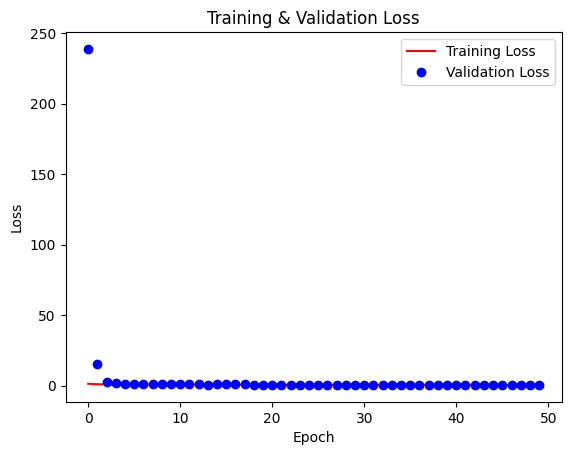

In [19]:
plt.plot(range(50), results.history['loss'], 'r', label='Training Loss')
plt.plot(range(50), results.history['val_loss'], 'bo', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()


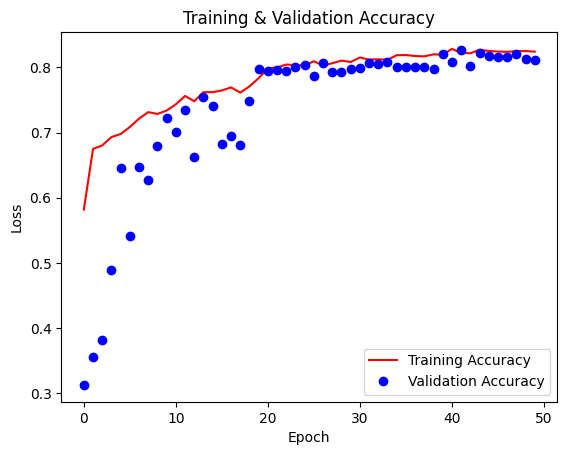

In [20]:
plt.plot(range(50), results.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(range(50), results.history['val_accuracy'], 'bo', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()


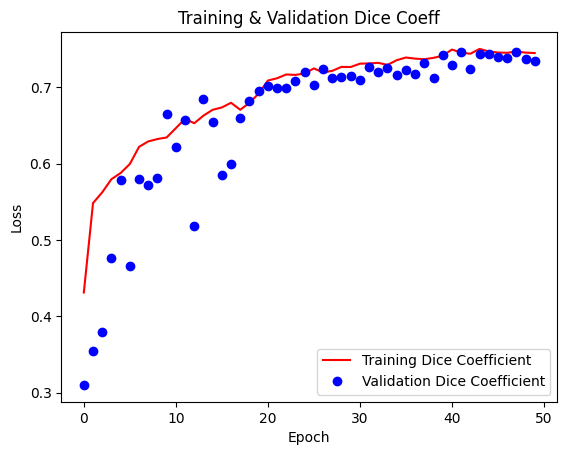

In [21]:
plt.plot(range(50), results.history['dice_coef'], 'r', label='Training Dice Coefficient')
plt.plot(range(50), results.history['val_dice_coef'], 'bo', label='Validation Dice Coefficient')
plt.title('Training & Validation Dice Coeff')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()


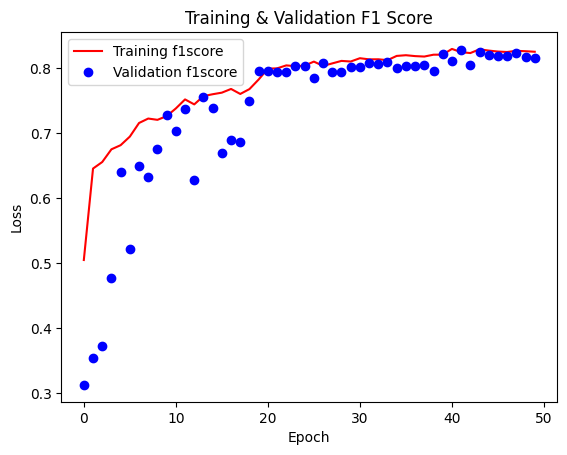

In [22]:
plt.plot(range(50), results.history['f1score'], 'r', label='Training f1score')
plt.plot(range(50), results.history['val_f1score'], 'bo', label='Validation f1score')
plt.title('Training & Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()


## Accuracy on test set is 0.7869 which is almost equal to training accuracy of 0.8241 and validation accuracy of 0.8105

In [23]:
print("Evaluate on test data")
eval_results = model.evaluate(test_generator)
print("test loss, test acc:", eval_results)

Evaluate on test data
25/25 [==============================] - 3s 130ms/step - loss: 0.6254 - accuracy: 0.7869 - dice_coef: 0.6989 - f1score: 0.7900 - specifity: 0.9726 - sensitivity: 0.6989
test loss, test acc: [0.6254329681396484, 0.7869258522987366, 0.6988545656204224, 0.789966881275177, 0.9726231098175049, 0.6988537907600403]


# Results on 5 test images

(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08137.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08137.png'))
1/1 [==============================] - 0s 90ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08043.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08043.png'))
1/1 [==============================] - 0s 20ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08095.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08095.png'))
1/1 [==============================] - 0s 22ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_07991.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_07991.png'))
1/1 [==============================] - 0s 19ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_07993.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_07993.png'))
1/1 [==============================] - 0s 19ms/step


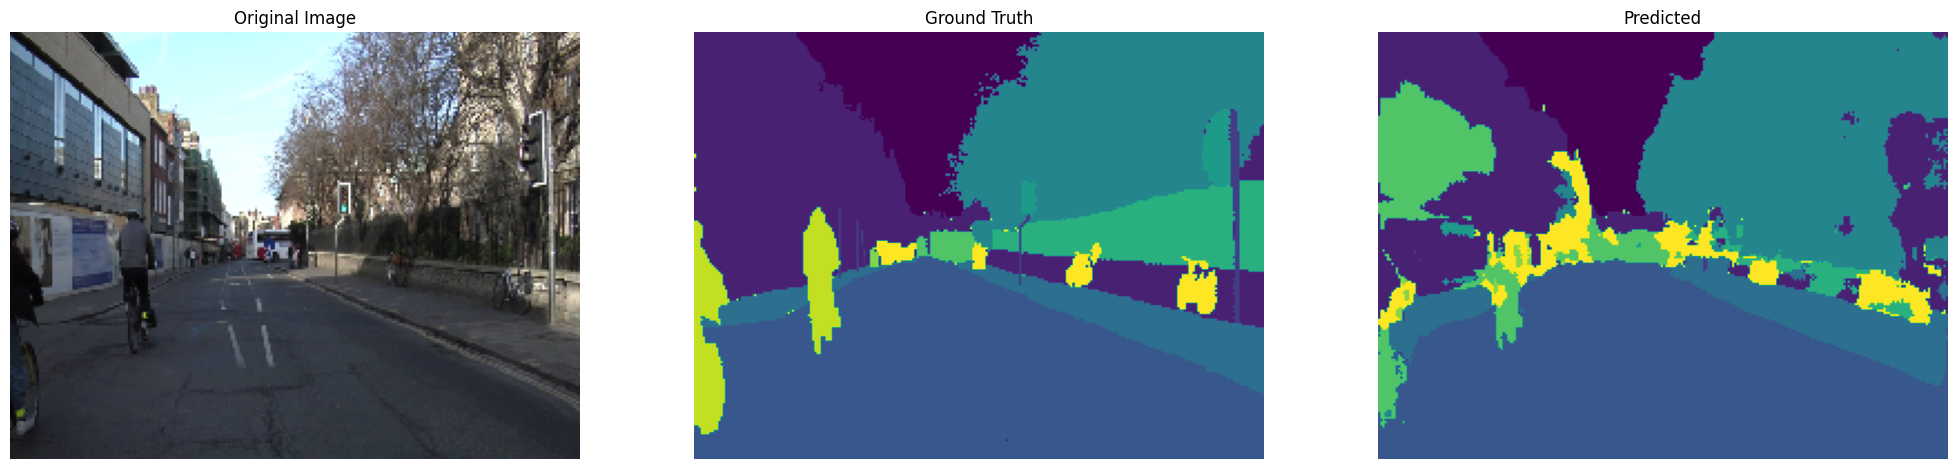

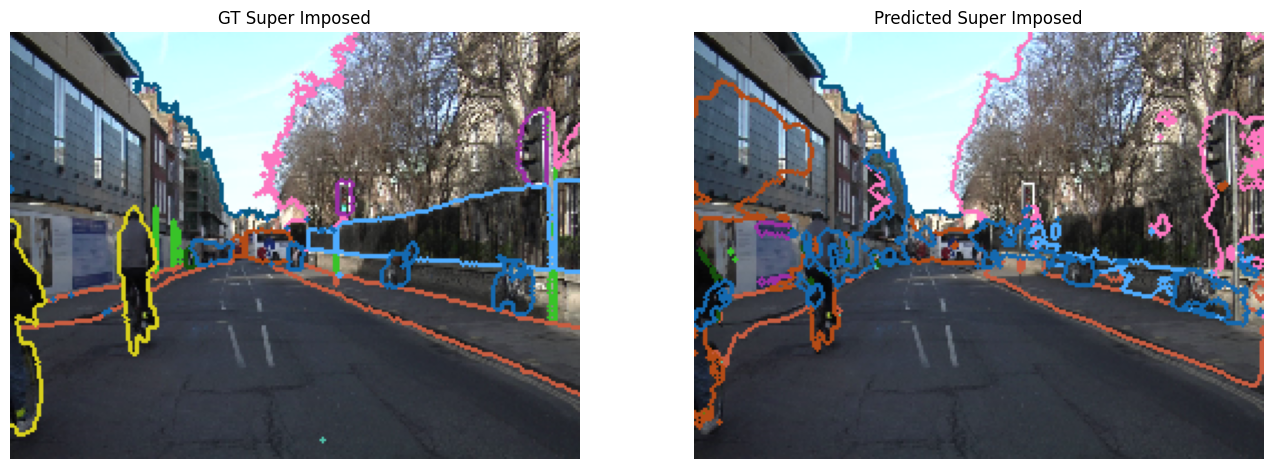

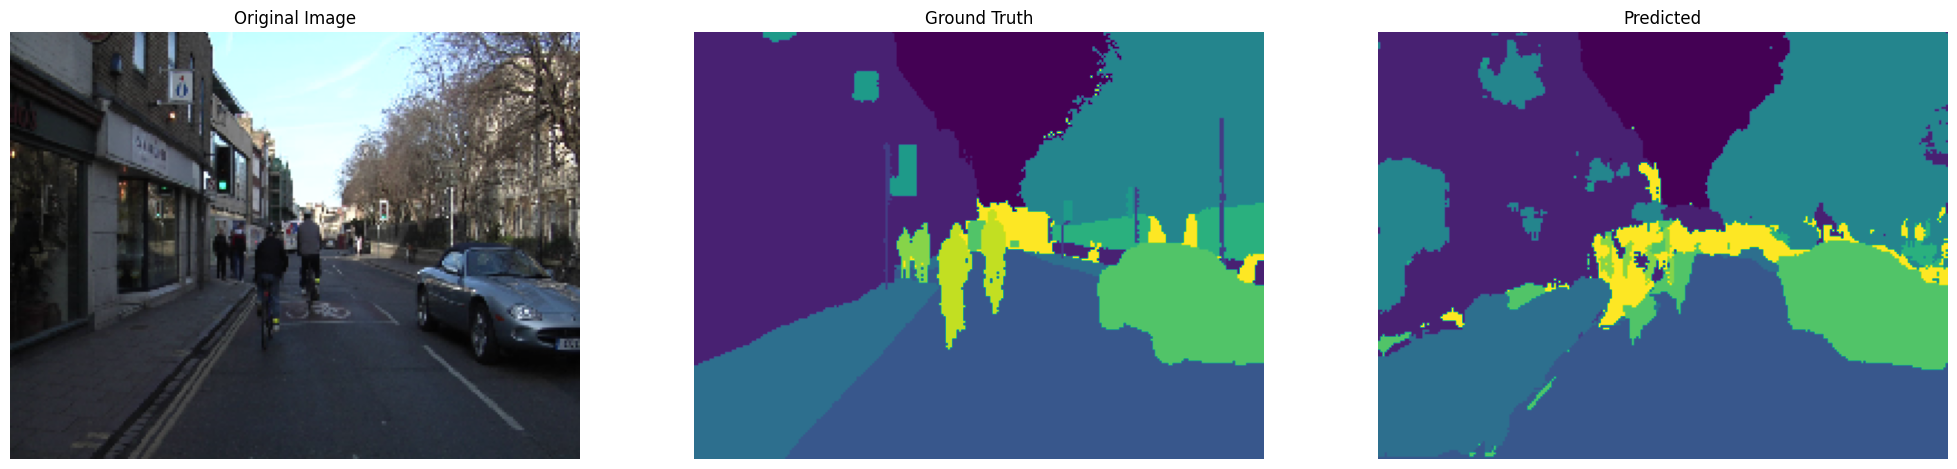

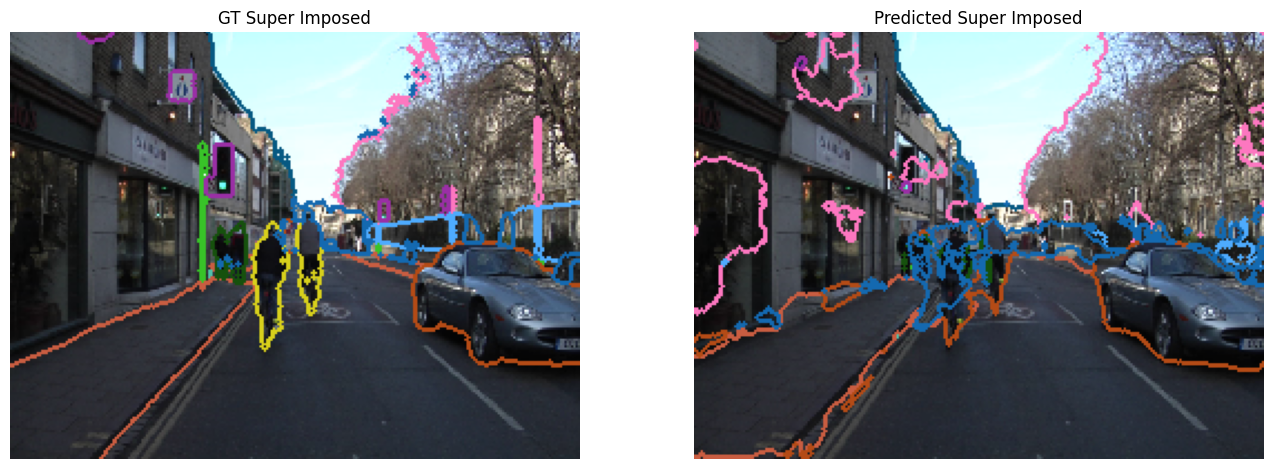

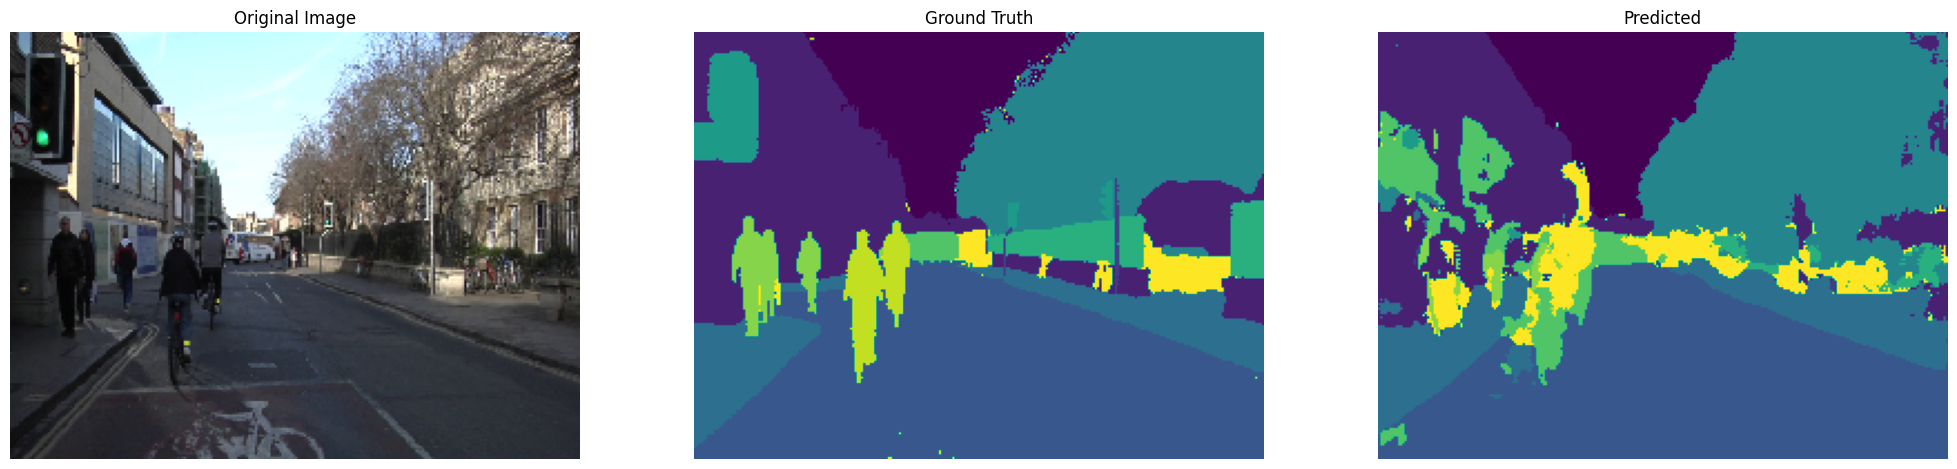

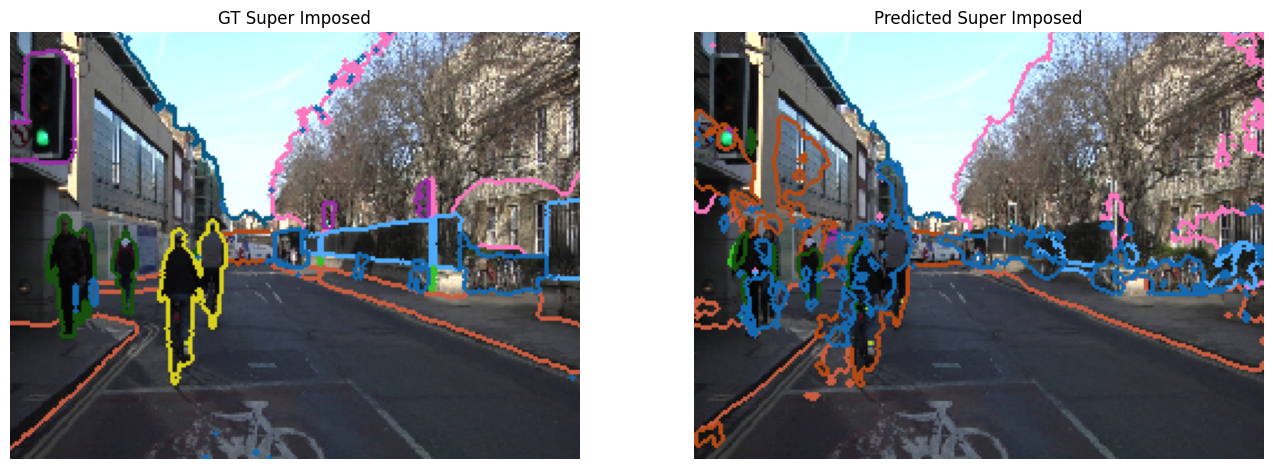

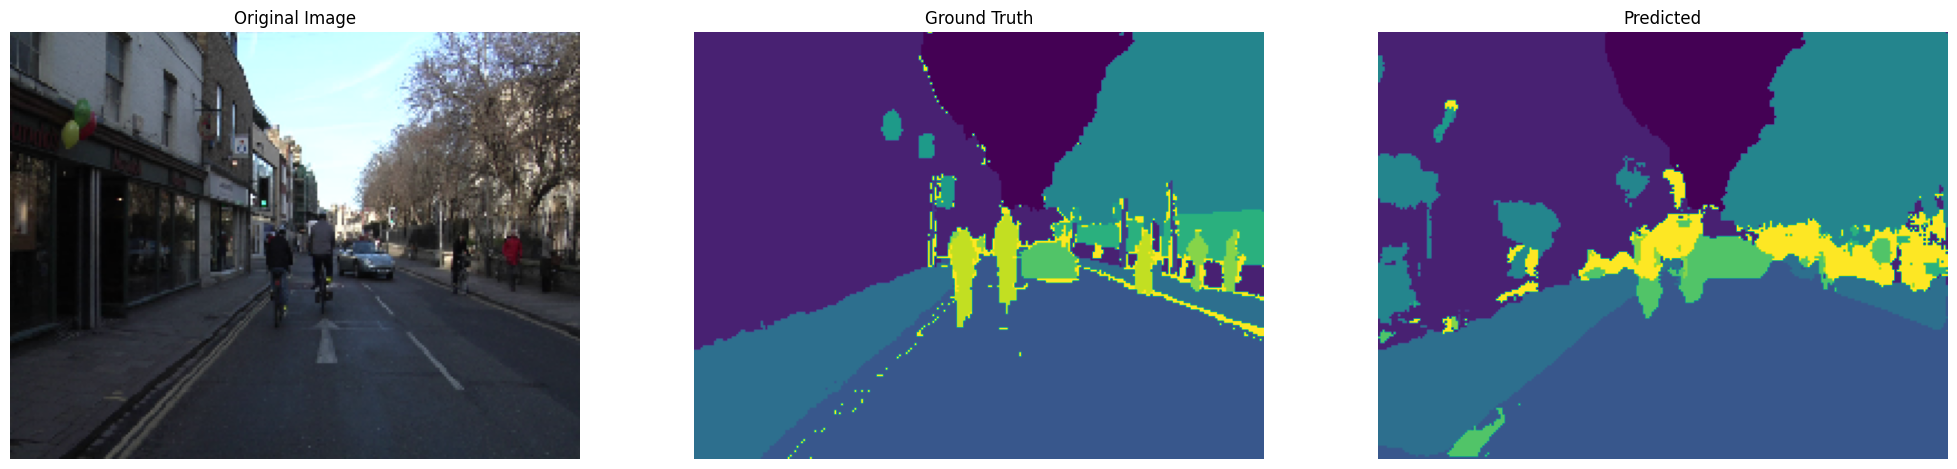

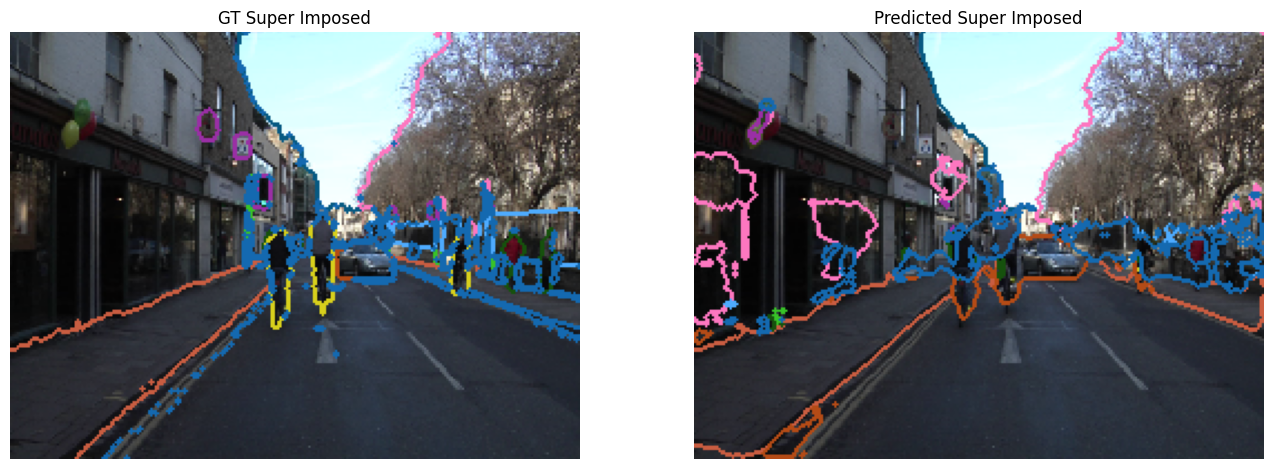

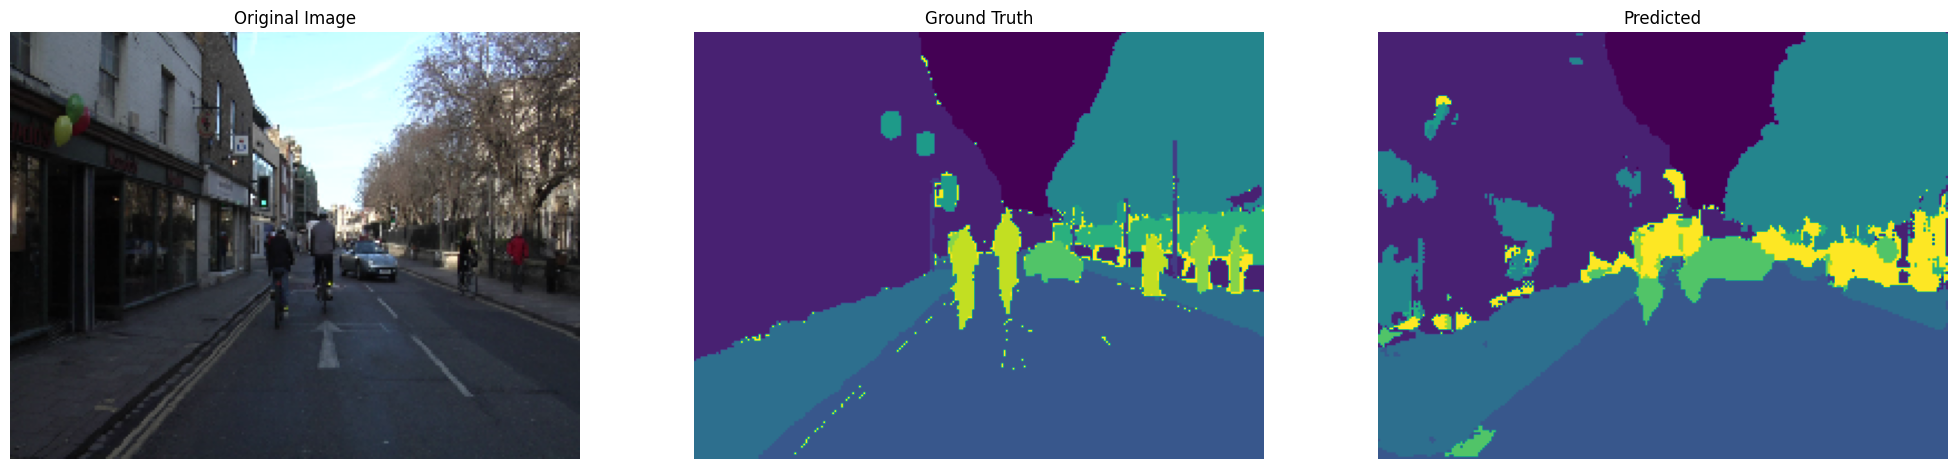

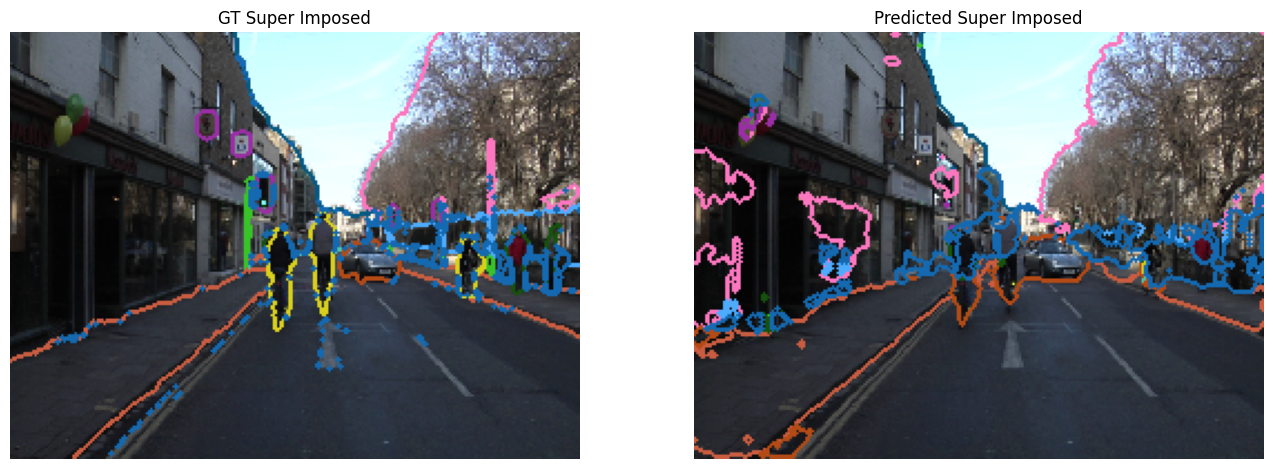

In [29]:
for i in range(5):
    img_mask = test_pair[i*2]
    print(img_mask)
    img= img_to_array(load_img(img_mask[0] , target_size= img_size))
    gt_img = img_to_array(load_img(img_mask[1] , target_size= img_size, grayscale=True))
    pred_label = make_prediction(model, img_mask[0], (img_size[0],img_size[1],3))
    super_imposed_gt = get_image_with_mask_imposed(img, gt_img[:, :, 0], 12, COLORS)
    super_imposed_pred = get_image_with_mask_imposed(img, pred_label, 12, COLORS)
    plot_images([img/255, gt_img, pred_label, super_imposed_gt/255, super_imposed_pred/255], ['Original Image', 'Ground Truth', 'Predicted', 'GT Super Imposed', 'Predicted Super Imposed'])